In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
from pprint import pprint

# Text processing
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [2]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target  )
    facet.add_legend()
    
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
complaints = pd.read_csv('cfpb_data_with_clean_zip.csv')
complaints.head()

In [5]:
complaints = complaints[(complaints['Consumer.complaint.narrative'].notna())
                                & (complaints['Consumer.complaint.narrative'] != '')]
complaints.reset_index(drop=True, inplace=True)

Build the Wordcloud

In [6]:
complaints_df = complaints.copy()
complaints_df['cleaned_narrative'] = complaints_df['Consumer.complaint.narrative']\
    .str.lower()\
    .str.replace(r'\b[Xx]+\b', '', regex=True)\
    .str.replace(r'usc', '', regex=True)\
    .str.replace(r'[0-9]+', '', regex=True)\
    .str.replace(r'[^a-zA-Z\s]', '', regex=True)

In [30]:
def tokenize_sentences(sentences):
    for sentence in sentences:
        yield([word for word in gensim.utils.simple_preprocess(str(sentence), deacc=True) if word not in stop_words])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

unique_complaints = complaints_df[complaints_df.duplicated(subset=['Consumer.complaint.narrative'], keep='first')]
narratives = unique_complaints['cleaned_narrative'].values.tolist()

narratives_words = list(tokenize_sentences(narratives))

bigram_words = gensim.models.Phrases(narratives_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_words = gensim.models.Phrases(bigram_words[narratives_words], threshold=100)

bigram_model = gensim.models.phrases.Phraser(bigram_words)
trigram_model = gensim.models.phrases.Phraser(trigram_words)

narratives_bigrams = [bigram_model[narrative] for narrative in narratives_words]
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

narratives_lemmatized = lemmatization(narratives_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(narratives_lemmatized[:1])

KeyboardInterrupt: 

In [8]:
def build_corpus_and_dict(cleaned_texts):
    # print(type(cleaned_texts[0]))
    # Tokenize the cleaned texts
    # texts = [re.sub(r'[^a-zA-Z\s]', '', str(text)).split() for text in cleaned_texts]    

    try:
        # Create a dictionary representation of the documents.
        dictionary = corpora.Dictionary(cleaned_texts)
        # Filter out words that occur in less than 20 documents, or more than 50% of the documents.
        dictionary.filter_extremes(no_below=20, no_above=0.5)
        # Bag-of-words representation of the documents.
        corpus = [dictionary.doc2bow(text) for text in cleaned_texts]
    except Exception as ex:
        print(ex)
    
    return corpus, dictionary

In [9]:
corpus, dictionary = build_corpus_and_dict(narratives_lemmatized)

In [10]:
# Set up the LDA model - computes a fixed set of topics
lda_model = gensim.models.LdaModel(corpus, num_topics=40, id2word=dictionary, passes=1, update_every=5, chunksize=10000)

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f'Processing {num_topics} topics')
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=2,
            update_every=5,
            chunksize=10000,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=narratives_lemmatized, 
                                                        start=4, 
                                                        limit=40, 
                                                        step=2)

Processing 4 topics
Processing 6 topics
Processing 8 topics
Processing 10 topics
Processing 12 topics
Processing 14 topics
Processing 16 topics
Processing 18 topics
Processing 20 topics
Processing 22 topics
Processing 24 topics
Processing 26 topics
Processing 28 topics
Processing 30 topics
Processing 32 topics
Processing 34 topics
Processing 36 topics
Processing 38 topics


In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=narratives_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.4162480038648475

Coherence Score:  0.4981778849116635


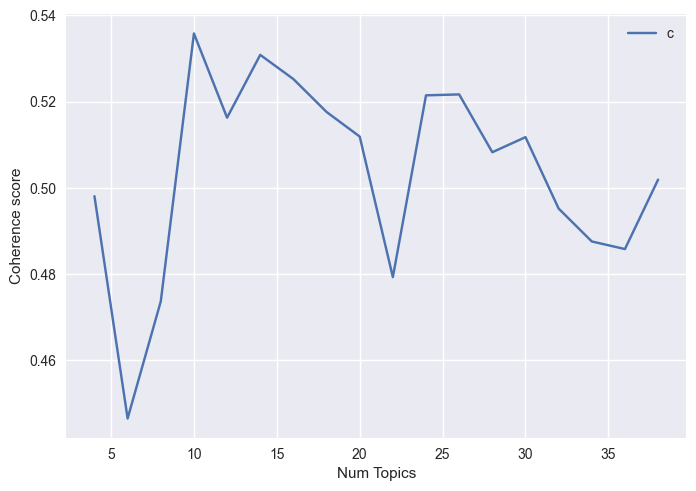

In [20]:
## Show graph
limit=40; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
best_model = model_list[coherence_values.index(max(coherence_values))]
# best_model = model_list[10]
pprint(best_model.print_topics(num_words=10))

[(0,
  '0.068*"consumer" + 0.039*"information" + 0.016*"reporting" + 0.015*"right" '
  '+ 0.014*"agency" + 0.014*"debt" + 0.012*"dispute" + 0.012*"law" + '
  '0.011*"creditor" + 0.010*"request"'),
 (1,
  '0.020*"information" + 0.015*"payment" + 0.014*"remove" + 0.012*"company" + '
  '0.011*"time" + 0.011*"get" + 0.011*"late" + 0.010*"pay" + '
  '0.009*"inaccurate" + 0.009*"loan"'),
 (2,
  '0.037*"claim" + 0.028*"debt" + 0.020*"collection" + 0.018*"reporting" + '
  '0.015*"payment" + 0.013*"compliance" + 0.012*"document" + 0.012*"allege" + '
  '0.010*"full" + 0.010*"proof"'),
 (3,
  '0.096*"consumer" + 0.055*"information" + 0.041*"block" + 0.038*"agency" + '
  '0.032*"identity" + 0.032*"reporting" + 0.031*"section" + 0.028*"theft" + '
  '0.019*"file" + 0.015*"result"'),
 (4,
  '0.022*"day" + 0.019*"dispute" + 0.018*"m" + 0.016*"score" + '
  '0.014*"transunion" + 0.013*"attempt" + 0.013*"cause" + 0.013*"inaccurate" + '
  '0.013*"debt" + 0.012*"information"'),
 (5,
  '0.032*"information" 

In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.106224  0.015153       1        1  16.900827
8      0.054058 -0.086203       2        1  15.888384
7      0.011828 -0.056987       3        1  11.403339
3     -0.182113  0.029148       4        1   9.576188
2      0.119900  0.208438       5        1   9.295736
6     -0.162609  0.069166       6        1   8.727527
0     -0.043068  0.029748       7        1   7.800008
4      0.103061 -0.022263       8        1   7.562794
5      0.048839 -0.110388       9        1   7.362216
9     -0.056120 -0.075812      10        1   5.482981, topic_info=           Term           Freq          Total Category  logprob  loglift
7      consumer  110820.000000  110820.000000  Default  30.0000  30.0000
139     section   69338.000000   69338.000000  Default  29.0000  29.0000
140       state   45595.000000   45595.000000  Default  28.0000  28.0000
260       theft   38759.000000   38759.000000  Default  27.0000  27.0000
106   reporting   76610.000000   76610.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
186        open    2366.127452   19795.472248  Topic10  -4.7130   0.7793
132      agency    2791.004894   48215.886338  Topic10  -4.5479   0.0542
7      consumer    2952.039786  110820.666057  Topic10  -4.4918  -0.7219
70      dispute    2416.625028   44771.928411  Topic10  -4.6919  -0.0157
80   inaccurate    2172.402655   36826.874798  Topic10  -4.7985   0.0731

[890 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1040      1  0.897993  absolutely_fe
1040      2  0.028443  absolutely_fe
1040      7  0.012190  absolutely_fe
1040      8  0.032507  absolutely_fe
1040      9  0.028443  absolutely_fe
...     ...       ...            ...
1076      2  0.007193   youre_claime
1076      6  0.040759   youre_claime
1076      7  0.915870   youre_claime
1076      9  0.009590   youre_claime
1076     10  0.021578   youre_claime

[5060 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 8, 4, 3, 7, 1, 5, 6, 10])

In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

def get_compound_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

def get_neutral_sentiment(text):
    return analyzer.polarity_scores(text)['neu']

def get_positive_sentiment(text):
    return analyzer.polarity_scores(text)['pos']

def get_negative_sentiment(text):
    return analyzer.polarity_scores(text)['neg']

complaints_df['compound_sentiment'] = complaints_df['cleaned_narrative'].apply(get_compound_sentiment)

Text(0, 0.5, 'Number of complaints')

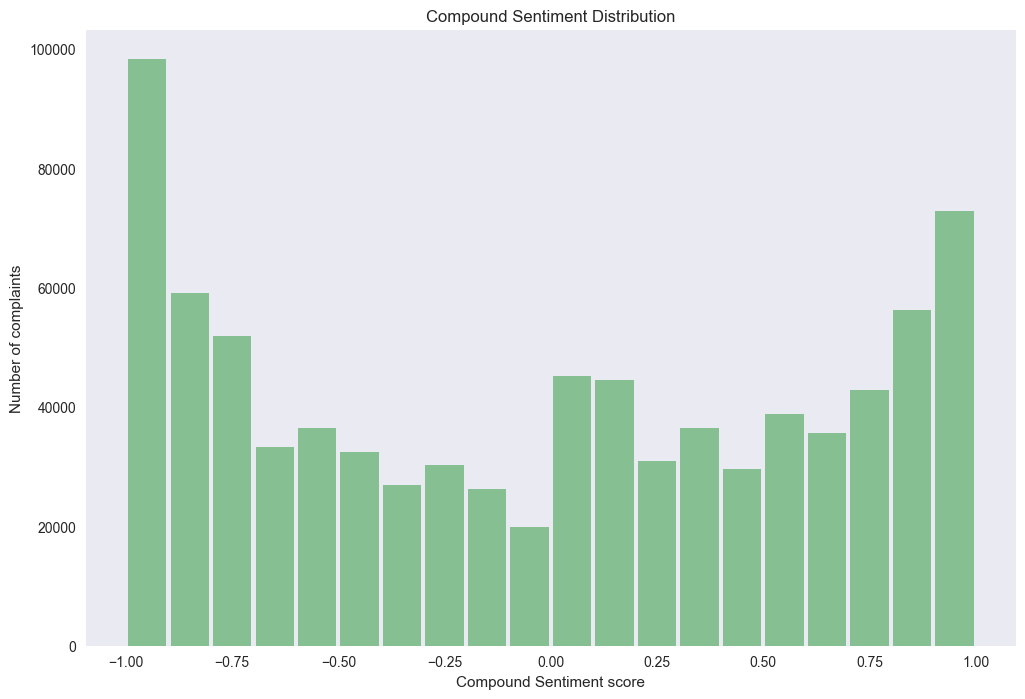

In [29]:
complaints_df.hist(column='compound_sentiment', bins=20, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.title('Compound Sentiment Distribution')
plt.xlabel('Compound Sentiment score')
plt.ylabel('Number of complaints')

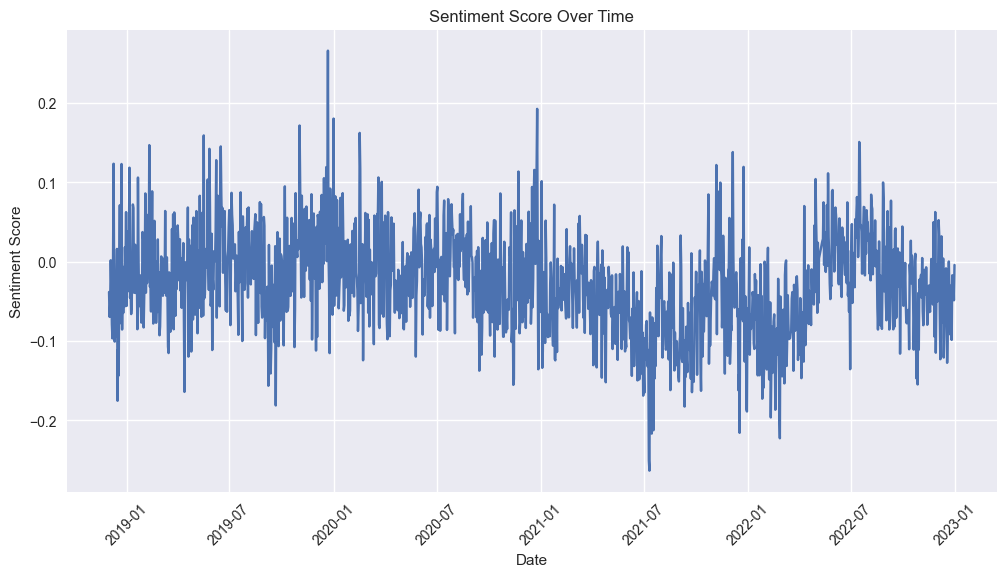

In [31]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'complaints_df' with a 'Date.received' column and 'compound_sentiment' column

# Convert 'Date.received' column to datetime
complaints_df['Date.received'] = pd.to_datetime(complaints_df['Date.received'])

# Group by date and calculate the average sentiment score
sentiment_over_time = complaints_df.groupby('Date.received')['compound_sentiment'].mean()

# Plot the sentiment score over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_over_time.index, sentiment_over_time.values)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Over Time')
plt.xticks(rotation=45)
plt.show()